In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)

# Rutas
BASE_DIR = Path().resolve().parent
DATA_PATH = BASE_DIR / 'data' / 'gold' / 'model' / 'regression_timeseries_dataset.parquet'

In [2]:
# Cargar datos
df = pd.read_parquet(DATA_PATH)
print(f"Shape: {df.shape}")
print(f"\nColumnas: {df.columns.tolist()}")
df.head(10)

Shape: (190, 16)

Columnas: ['anio_mes', 'total_delitos', 'poblacion_total', 'fecha', 'tasa_global', 'lag_1', 'lag_3', 'lag_12', 'roll_mean_3', 'roll_mean_12', 'pct_change_1', 'pct_change_12', 'anio', 'mes', 'mes_sin', 'mes_cos']


,anio_mes,total_delitos,poblacion_total,fecha,tasa_global,lag_1,lag_3,lag_12,roll_mean_3,roll_mean_12,pct_change_1,pct_change_12,anio,mes,mes_sin,mes_cos
0,2010-01,1516,3852684,2010-01-01,39.349191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,1,5.000000e-01,8.660254e-01
1,2010-02,1231,3896232,2010-02-01,31.594628,1516.0,NaN,NaN,NaN,NaN,-0.187995,NaN,2010,2,8.660254e-01,5.000000e-01
2,2010-03,1379,3875808,2010-03-01,35.579678,1231.0,NaN,NaN,1375.333333,NaN,0.120227,NaN,2010,3,1.000000e+00,6.123234e-17
3,2010-04,1552,3857640,2010-04-01,40.231852,1379.0,1516.0,NaN,1387.333333,NaN,0.125453,NaN,2010,4,8.660254e-01,-5.000000e-01
4,2010-05,1503,3912430,2010-05-01,38.416023,1552.0,1231.0,NaN,1478.000000,NaN,-0.031572,NaN,2010,5,5.000000e-01,-8.660254e-01
5,2010-06,1276,3815448,2010-06-01,33.442993,1503.0,1379.0,NaN,1443.666667,NaN,-0.151031,NaN,2010,6,1.224647e-16,-1.000000e+00
6,2010-07,1412,3806326,2010-07-01,37.096139,1276.0,1552.0,NaN,1397.000000,NaN,0.106583,NaN,2010,7,-5.000000e-01,-8.660254e-01
7,2010-08,1472,3886504,2010-08-01,37.874655,1412.0,1503.0,NaN,1386.666667,NaN,0.042493,NaN,2010,8,-8.660254e-01,-5.000000e-01
8,2010-09,1534,3797082,2010-09-01,40.399444,1472.0,1276.0,NaN,1472.666667,NaN,0.042120,NaN,2010,9,-1.000000e+00,-1.836970e-16
9,2010-10,1533,3861028,2010-10-01,39.704452,1534.0,1412.0,NaN,1513.000000,NaN,-0.000652,NaN,2010,10,-8.660254e-01,5.000000e-01


In [3]:
# Info general
print("=" * 60)
print("INFO GENERAL")
print("=" * 60)
print(f"\nTotal meses: {len(df)}")

if 'fecha' in df.columns:
    df['fecha'] = pd.to_datetime(df['fecha'])
    print(f"Período: {df['fecha'].min()} a {df['fecha'].max()}")
elif 'anio_mes' in df.columns:
    print(f"Período: {df['anio_mes'].min()} a {df['anio_mes'].max()}")

print(f"\nEstadísticas del target:")
print(df['total_delitos'].describe())

INFO GENERAL

Total meses: 190
Período: 2010-01-01 00:00:00 a 2025-10-01 00:00:00

Estadísticas del target:
count     190.000000
mean     2537.894737
std       767.466615
min      1072.000000
25%      1997.750000
50%      2516.500000
75%      2887.500000
max      4574.000000
Name: total_delitos, dtype: float64


## 1. Serie Temporal Principal

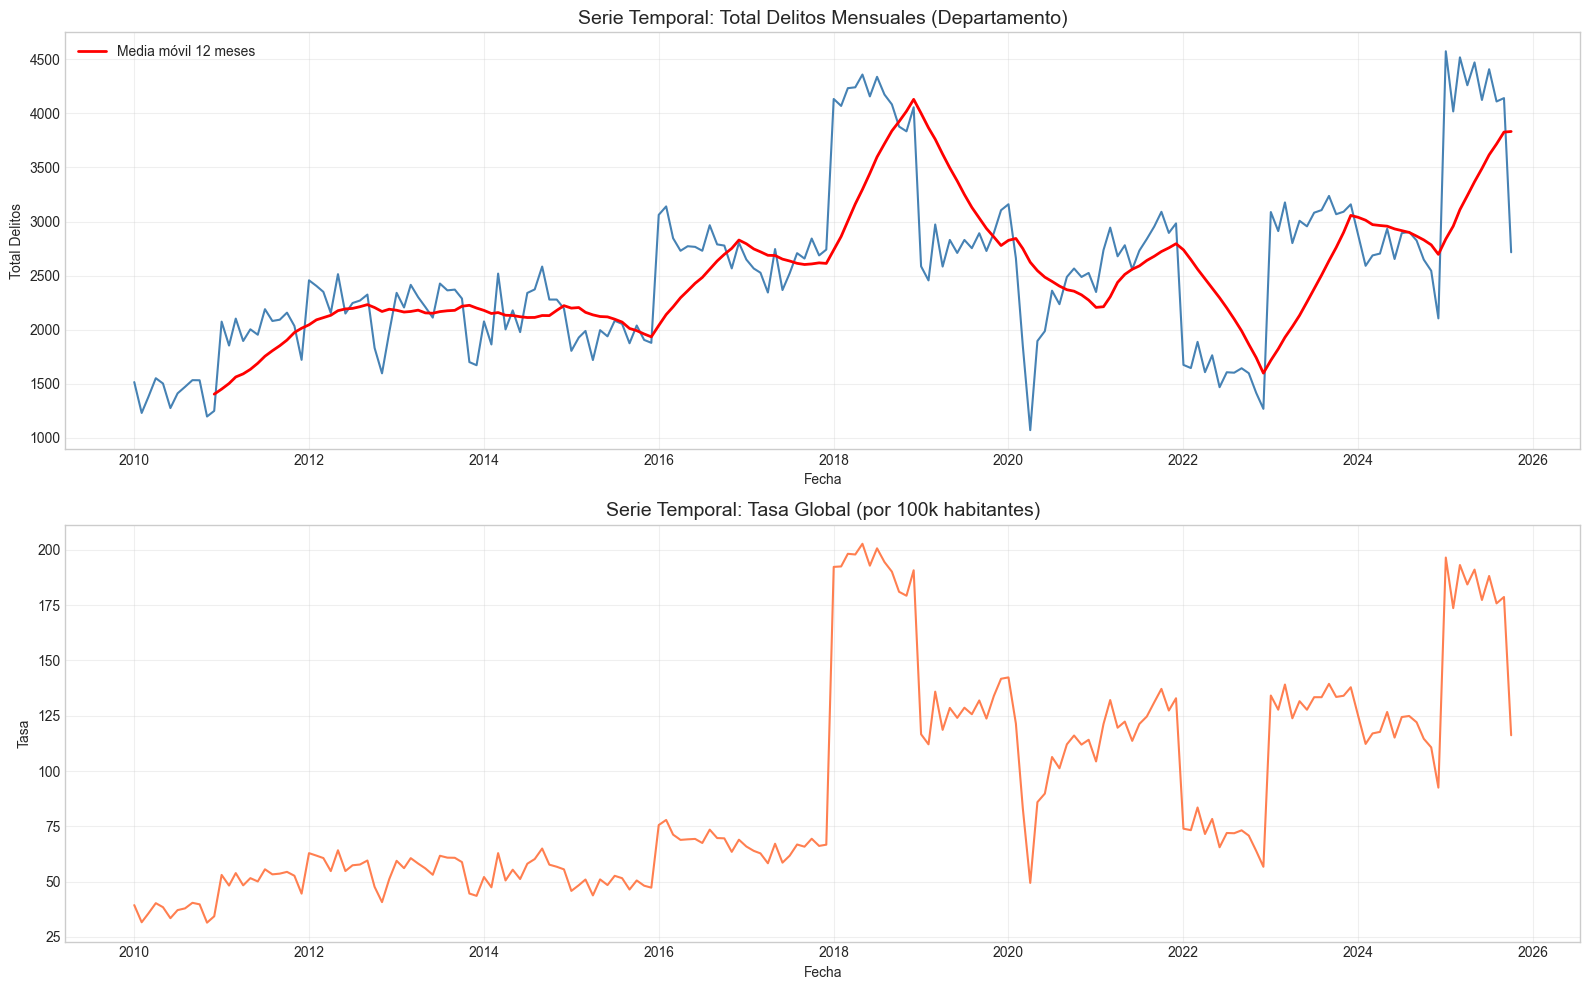

In [4]:
# Preparar índice temporal
if 'fecha' in df.columns:
    df = df.sort_values('fecha')
    df = df.set_index('fecha')
elif 'anio_mes' in df.columns:
    df['fecha'] = pd.to_datetime(df['anio_mes'])
    df = df.sort_values('fecha')
    df = df.set_index('fecha')

# Visualización de la serie
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Serie original
axes[0].plot(df.index, df['total_delitos'], linewidth=1.5, color='steelblue')
axes[0].set_title('Serie Temporal: Total Delitos Mensuales (Departamento)', fontsize=14)
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Total Delitos')
axes[0].grid(True, alpha=0.3)

# Añadir media móvil
if len(df) > 12:
    rolling_12 = df['total_delitos'].rolling(window=12).mean()
    axes[0].plot(df.index, rolling_12, linewidth=2, color='red', label='Media móvil 12 meses')
    axes[0].legend()

# Tasa global (si existe)
if 'tasa_global' in df.columns:
    axes[1].plot(df.index, df['tasa_global'], linewidth=1.5, color='coral')
    axes[1].set_title('Serie Temporal: Tasa Global (por 100k habitantes)', fontsize=14)
    axes[1].set_xlabel('Fecha')
    axes[1].set_ylabel('Tasa')
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].set_visible(False)

plt.tight_layout()
plt.show()

## 2. Descomposición de la Serie

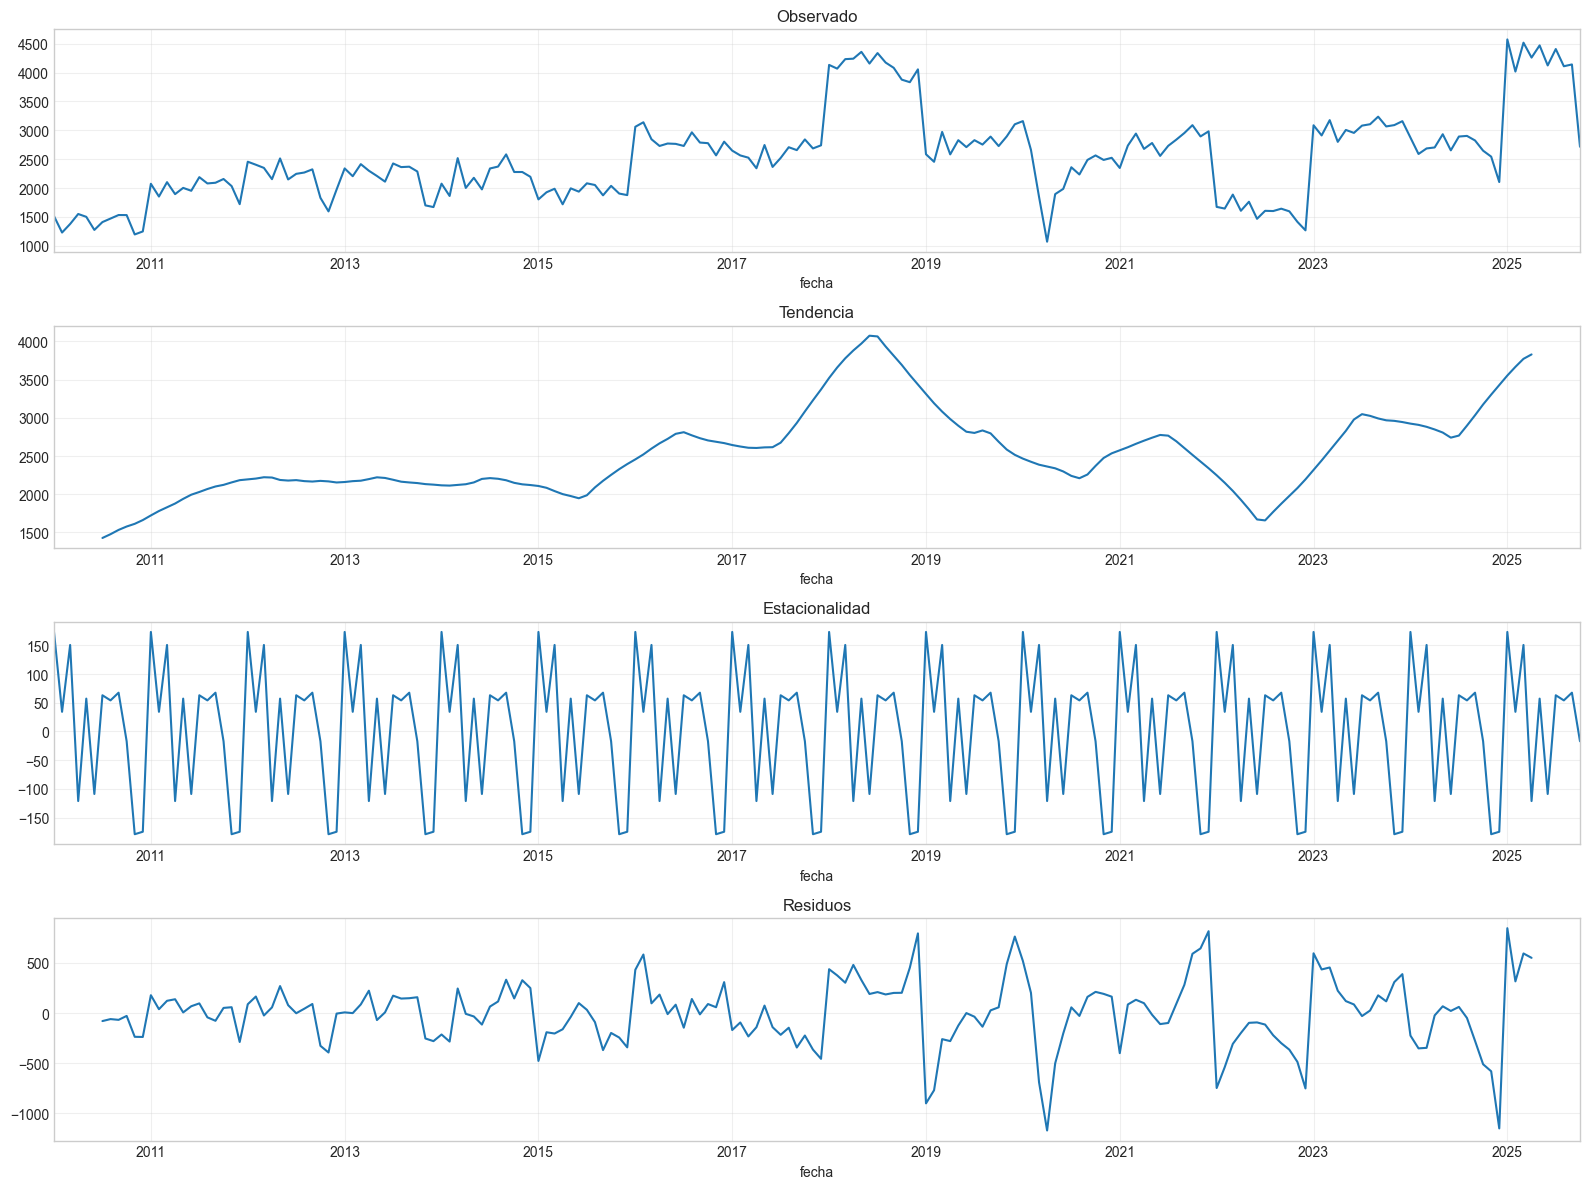


Fuerza de estacionalidad: 0.108
(> 0.6 indica estacionalidad significativa)


In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición estacional
try:
    decomposition = seasonal_decompose(df['total_delitos'].dropna(), model='additive', period=12)
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    
    decomposition.observed.plot(ax=axes[0], title='Observado')
    decomposition.trend.plot(ax=axes[1], title='Tendencia')
    decomposition.seasonal.plot(ax=axes[2], title='Estacionalidad')
    decomposition.resid.plot(ax=axes[3], title='Residuos')
    
    for ax in axes:
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Fuerza de estacionalidad
    var_seasonal = decomposition.seasonal.var()
    var_residual = decomposition.resid.dropna().var()
    strength_seasonal = 1 - (var_residual / (var_seasonal + var_residual))
    print(f"\nFuerza de estacionalidad: {strength_seasonal:.3f}")
    print("(> 0.6 indica estacionalidad significativa)")
    
except Exception as e:
    print(f"No se pudo descomponer la serie: {e}")

## 3. Test de Estacionariedad

In [6]:
from statsmodels.tsa.stattools import adfuller, kpss

print("=" * 60)
print("TESTS DE ESTACIONARIEDAD")
print("=" * 60)

# ADF Test
try:
    adf_result = adfuller(df['total_delitos'].dropna())
    print(f"\nADF Test (H0: Serie tiene raíz unitaria / no estacionaria):")
    print(f"  Estadístico: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Valores críticos: {adf_result[4]}")
    if adf_result[1] < 0.05:
        print(f"  ✅ Serie es ESTACIONARIA (rechazamos H0)")
    else:
        print(f"  ⚠️ Serie NO es estacionaria (no rechazamos H0)")
except Exception as e:
    print(f"Error en ADF: {e}")

# KPSS Test
try:
    kpss_result = kpss(df['total_delitos'].dropna(), regression='c')
    print(f"\nKPSS Test (H0: Serie es estacionaria):")
    print(f"  Estadístico: {kpss_result[0]:.4f}")
    print(f"  p-value: {kpss_result[1]:.4f}")
    if kpss_result[1] > 0.05:
        print(f"  ✅ Serie es ESTACIONARIA (no rechazamos H0)")
    else:
        print(f"  ⚠️ Serie NO es estacionaria (rechazamos H0)")
except Exception as e:
    print(f"Error en KPSS: {e}")

TESTS DE ESTACIONARIEDAD

ADF Test (H0: Serie tiene raíz unitaria / no estacionaria):
  Estadístico: -3.2087
  p-value: 0.0195
  Valores críticos: {'1%': np.float64(-3.465620397124192), '5%': np.float64(-2.8770397560752436), '10%': np.float64(-2.5750324547306476)}
  ✅ Serie es ESTACIONARIA (rechazamos H0)

KPSS Test (H0: Serie es estacionaria):
  Estadístico: 0.7822
  p-value: 0.0100
  ⚠️ Serie NO es estacionaria (rechazamos H0)


C:\Users\57318\AppData\Local\Temp\ipykernel_2160\1005615581.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df['total_delitos'].dropna(), regression='c')


## 4. Autocorrelación

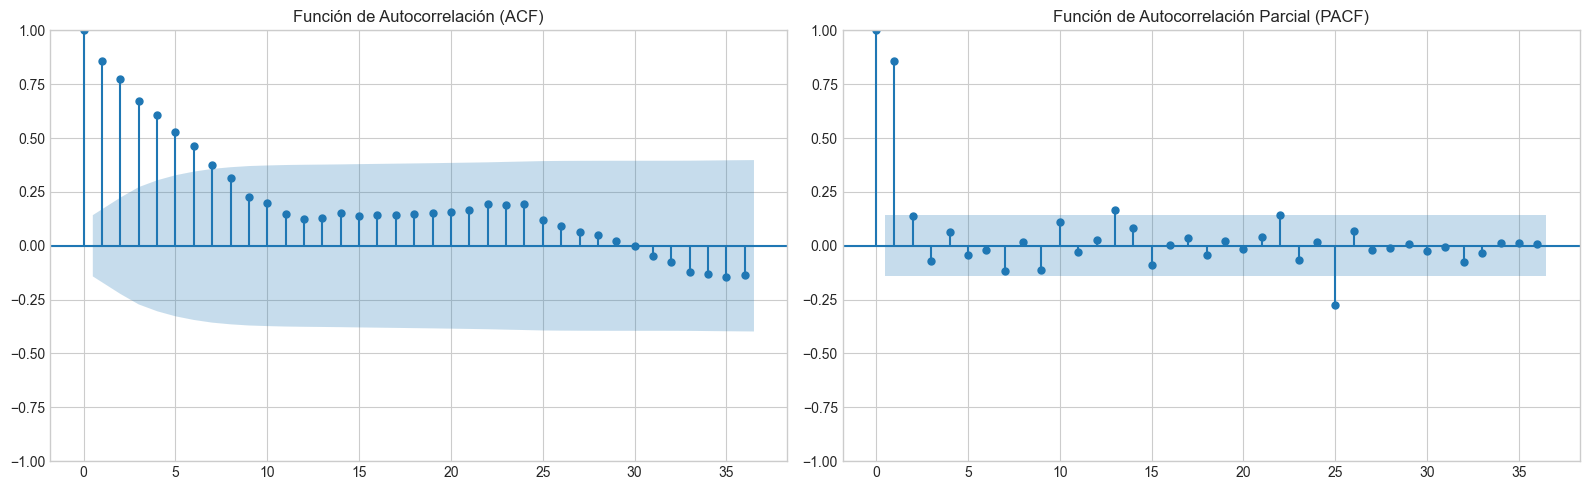


Interpretación:
- Picos significativos en lag 12 indican estacionalidad anual
- Decaimiento lento en ACF indica tendencia
- PACF ayuda a identificar orden AR del modelo


In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF
plot_acf(df['total_delitos'].dropna(), lags=36, ax=axes[0])
axes[0].set_title('Función de Autocorrelación (ACF)')

# PACF
plot_pacf(df['total_delitos'].dropna(), lags=36, ax=axes[1])
axes[1].set_title('Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

print("\nInterpretación:")
print("- Picos significativos en lag 12 indican estacionalidad anual")
print("- Decaimiento lento en ACF indica tendencia")
print("- PACF ayuda a identificar orden AR del modelo")

## 5. Features de Lag Existentes

In [8]:
# Verificar features de lag
lag_cols = [c for c in df.columns if 'lag' in c.lower()]
roll_cols = [c for c in df.columns if 'roll' in c.lower()]
pct_cols = [c for c in df.columns if 'pct' in c.lower()]

print("=" * 60)
print("FEATURES TEMPORALES EXISTENTES")
print("=" * 60)

print(f"\nLag features: {lag_cols}")
print(f"Rolling features: {roll_cols}")
print(f"Percent change features: {pct_cols}")

# Estadísticas de lag features
if lag_cols:
    print(f"\nEstadísticas de lag features:")
    print(df[lag_cols].describe().round(2))

FEATURES TEMPORALES EXISTENTES

Lag features: ['lag_1', 'lag_3', 'lag_12']
Rolling features: ['roll_mean_3', 'roll_mean_12']
Percent change features: ['pct_change_1', 'pct_change_12']

Estadísticas de lag features:
         lag_1    lag_3   lag_12
count   189.00   187.00   178.00
mean   2536.95  2519.96  2450.62
std     769.39   755.58   679.53
min    1072.00  1072.00  1072.00
25%    1996.00  1992.50  1980.25
50%    2514.00  2488.00  2441.50
75%    2892.00  2860.00  2828.75
max    4574.00  4574.00  4359.00


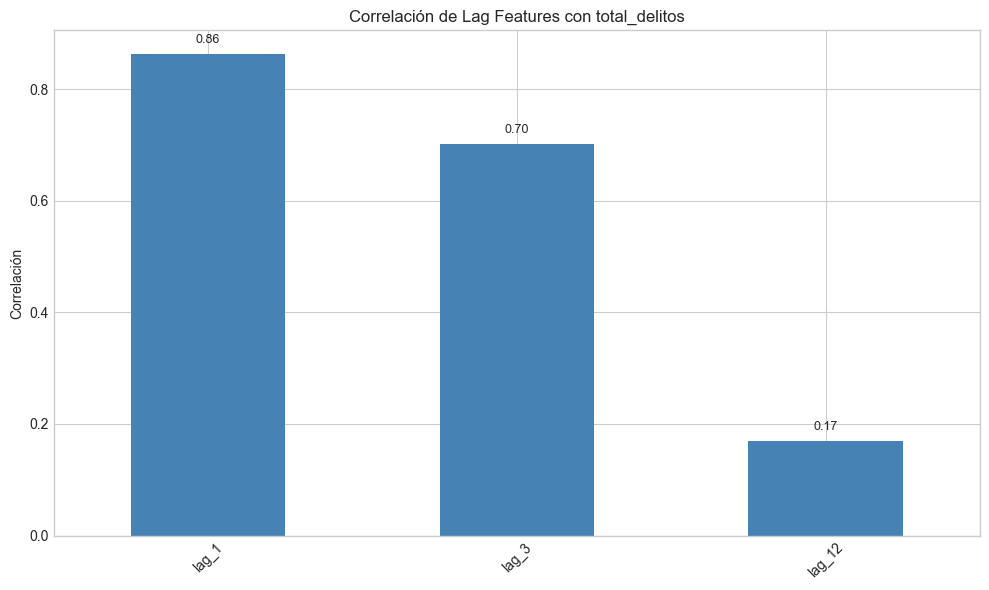

In [9]:
# Correlación de lags con target
if lag_cols:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    correlations = df[['total_delitos'] + lag_cols].corr()['total_delitos'].drop('total_delitos')
    correlations.plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title('Correlación de Lag Features con total_delitos')
    ax.set_ylabel('Correlación')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(correlations):
        ax.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## 6. Estacionalidad Mensual

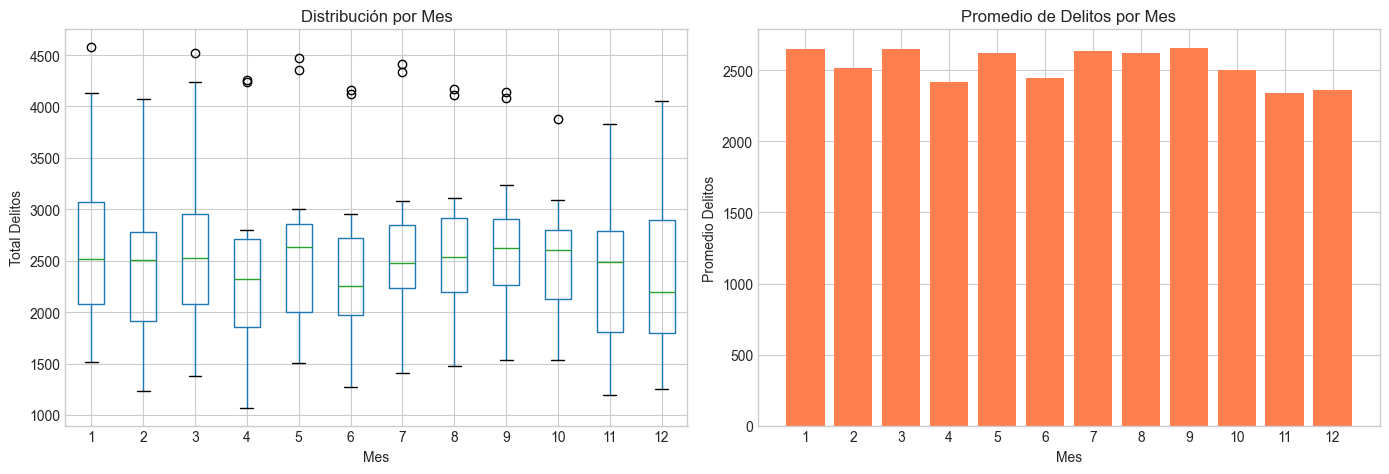


Mes con más delitos: 9 (promedio: 2656)
Mes con menos delitos: 11 (promedio: 2342)


In [10]:
# Patrón estacional por mes
if 'mes' in df.columns:
    df_reset = df.reset_index()
else:
    df_reset = df.reset_index()
    df_reset['mes'] = df_reset['fecha'].dt.month if 'fecha' in df_reset.columns else df_reset.index.month

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot por mes
df_reset.boxplot(column='total_delitos', by='mes', ax=axes[0])
axes[0].set_title('Distribución por Mes')
axes[0].set_xlabel('Mes')
axes[0].set_ylabel('Total Delitos')
plt.suptitle('')

# Promedio por mes
monthly_mean = df_reset.groupby('mes')['total_delitos'].mean()
axes[1].bar(monthly_mean.index, monthly_mean.values, color='coral')
axes[1].set_xlabel('Mes')
axes[1].set_ylabel('Promedio Delitos')
axes[1].set_title('Promedio de Delitos por Mes')
axes[1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

print(f"\nMes con más delitos: {monthly_mean.idxmax()} (promedio: {monthly_mean.max():.0f})")
print(f"Mes con menos delitos: {monthly_mean.idxmin()} (promedio: {monthly_mean.min():.0f})")

## 7. Conclusiones y Recomendaciones

In [11]:
print("=" * 60)
print("CONCLUSIONES")
print("=" * 60)

print(f"""
SERIE TEMPORAL:
  - Total observaciones: {len(df)}
  - Media: {df['total_delitos'].mean():.0f} delitos/mes
  - Std: {df['total_delitos'].std():.0f}
  - Rango: {df['total_delitos'].min():.0f} - {df['total_delitos'].max():.0f}

FEATURES EXISTENTES:
  - Lag features: {len(lag_cols)}
  - Rolling features: {len(roll_cols)}
  - Pct change features: {len(pct_cols)}

CARACTERÍSTICAS:
  - {'Estacionalidad anual detectada' if lag_cols else 'Verificar estacionalidad'}
  - Dataset pequeño ({len(df)} obs) - cuidado con overfitting
""")

print("\n" + "=" * 60)
print("RECOMENDACIONES PARA MODELO")
print("=" * 60)
print("""
1. MODELOS SUGERIDOS (serie temporal):
   - SARIMA / SARIMAX (estacionalidad + exógenas)
   - Prophet (robusto, maneja festivos)
   - XGBoost con features de lag
   - LSTM (si hay suficientes datos)

2. FEATURES ADICIONALES:
   - Festivos colombianos
   - Eventos especiales (elecciones, COVID)
   - Variables macroeconómicas (desempleo)

3. VALIDACIÓN:
   - Walk-forward validation
   - Train hasta 2023, test en 2024-2025
   - NO usar KFold (rompe temporalidad)

4. MÉTRICAS:
   - RMSE, MAE
   - MAPE (interpretable)
   - Comparar con baseline (naive, media móvil)

5. CONSIDERACIONES:
   - Dataset pequeño (< 200 obs)
   - Evitar modelos muy complejos
   - Preferir modelos interpretables
""")

CONCLUSIONES

SERIE TEMPORAL:
  - Total observaciones: 190
  - Media: 2538 delitos/mes
  - Std: 767
  - Rango: 1072 - 4574

FEATURES EXISTENTES:
  - Lag features: 3
  - Rolling features: 2
  - Pct change features: 2

CARACTERÍSTICAS:
  - Estacionalidad anual detectada
  - Dataset pequeño (190 obs) - cuidado con overfitting


RECOMENDACIONES PARA MODELO

1. MODELOS SUGERIDOS (serie temporal):
   - SARIMA / SARIMAX (estacionalidad + exógenas)
   - Prophet (robusto, maneja festivos)
   - XGBoost con features de lag
   - LSTM (si hay suficientes datos)

2. FEATURES ADICIONALES:
   - Festivos colombianos
   - Eventos especiales (elecciones, COVID)
   - Variables macroeconómicas (desempleo)

3. VALIDACIÓN:
   - Walk-forward validation
   - Train hasta 2023, test en 2024-2025
   - NO usar KFold (rompe temporalidad)

4. MÉTRICAS:
   - RMSE, MAE
   - MAPE (interpretable)
   - Comparar con baseline (naive, media móvil)

5. CONSIDERACIONES:
   - Dataset pequeño (< 200 obs)
   - Evitar modelos muy

## 8. Guardar Dataset Procesado

In [12]:
# Ruta para guardar dataset procesado
PROCESSED_DATA_PATH = BASE_DIR / 'data' / 'model' / 'regression_timeseries_dataset_processed.parquet'

# Crear carpeta si no existe
PROCESSED_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

# Resetear índice si es necesario y guardar
df_save = df.reset_index() if df.index.name is not None else df.copy()

df_save.to_parquet(PROCESSED_DATA_PATH, index=False)
print(f"✓ Dataset procesado guardado: {PROCESSED_DATA_PATH}")
print(f"  Shape: {df_save.shape}")
print(f"\nDataset contiene:")
print(f"  - Observaciones: {len(df_save)}")
print(f"  - Target: total_delitos (serie temporal mensual)")
print(f"  - Lag features: {len(lag_cols)}")
print(f"  - Rolling features: {len(roll_cols)}")
print(f"  - Uso: Modelado de series temporales (SARIMA, Prophet, XGBoost)")

✓ Dataset procesado guardado: C:\Users\57318\Downloads\mintic\Datos-al-Ecosistema\data\model\regression_timeseries_dataset_processed.parquet
  Shape: (190, 16)

Dataset contiene:
  - Observaciones: 190
  - Target: total_delitos (serie temporal mensual)
  - Lag features: 3
  - Rolling features: 2
  - Uso: Modelado de series temporales (SARIMA, Prophet, XGBoost)
